In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time
import numpy as np
import tensorflow as tf
import math
from scipy.stats import multivariate_normal as normal
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')

class Solver(object):
    def __init__(self,):
        self.valid_size = 512
        self.batch_size = 64
        self.num_iterations = 2000
        self.logging_frequency = 100
        self.lr_values = [5e-2, 5e-3, 1e-3]

        self.lr_boundaries = [1000, 1500]
        self.config = Config()

        self.model = WholeNet()
        self.y_init = self.model.y_init

        lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(self.lr_boundaries, self.lr_values)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)

    def train(self):
        """Training the model"""
        start_time = time.time()
        training_history = []
        dW = self.config.sample(self.valid_size)
        valid_data = dW
        for step in range(self.num_iterations+1):
            if step % self.logging_frequency == 0:
                loss, cost = self.model(valid_data, training=True)
                y_init = self.y_init.numpy()[0][0]
                elapsed_time = time.time() - start_time
                training_history.append([step, cost, y_init, loss])
                print("step: %5u, loss: %.4e, Y0: %.4e, cost: %.4e,  elapsed time: %3u" % (step, loss, y_init, cost, elapsed_time))
            self.train_step(self.config.sample(self.batch_size))
        print('Y0_true: %.4e' % y_init)
        self.training_history = training_history

    @tf.function
    def train_step(self, train_data):
        """Updating the gradients"""
        with tf.GradientTape(persistent=True) as tape:
            loss, cost = self.model(train_data, training = True)
        grad = tape.gradient(loss, self.model.trainable_variables)
        del tape
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))


class WholeNet(tf.keras.Model):
    """Building the neural network architecture"""
    def __init__(self):
        super(WholeNet, self).__init__()
        self.config = Config()
        self.y_init = tf.Variable(tf.random.normal([1, self.config.dim_y], mean=0, stddev=1, dtype=tf.dtypes.float64))
        self.z_net = FNNet()

    def call(self, dw, training):
        x_init = tf.ones([1, self.config.dim_x], dtype=tf.dtypes.float64) * 1.0
        time_stamp = np.arange(0, self.config.num_time_interval) * self.config.delta_t
        all_one_vec = tf.ones([tf.shape(dw)[0], 1], dtype=tf.dtypes.float64)
        x = tf.matmul(all_one_vec, x_init)
        y = tf.matmul(all_one_vec, self.y_init)
        l = 0.0 # The cost functional
        for t in range(0, self.config.num_time_interval):
            data = time_stamp[t], x, y
            z = self.z_net(data, training= True)
            u = self.config.u_fn(time_stamp[t], x, y, z)

            l = l + self.config.f_fn(time_stamp[t], x, u) * self.config.delta_t

            b_ = self.config.b_fn(time_stamp[t], x, y, z)
            sigma_ = self.config.sigma_fn(time_stamp[t], x, y, z)
            f_ = self.config.Hx_fn(time_stamp[t], x, y, z)

            x = x + b_ * self.config.delta_t + sigma_ * dw[:, :, t]
            y = y - f_ * self.config.delta_t + z * dw[:, :, t]

        delta = y + self.config.hx_tf(self.config.total_T, x)
        loss = tf.reduce_mean(tf.reduce_sum(delta**2, 1, keepdims=True))

        l = l + self.config.h_fn(self.config.total_T, x)
        cost = tf.reduce_mean(l)

        return loss, cost

class FNNet(tf.keras.Model):
    """ Define the feedforward neural network """
    def __init__(self):
        super(FNNet, self).__init__()
        self.config = Config()
        num_hiddens = [self.config.dim_x+10, self.config.dim_x+10, self.config.dim_x+10]
        self.bn_layers = [
            tf.keras.layers.BatchNormalization(
                momentum=0.99,
                epsilon=1e-6,
                beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
                gamma_initializer=tf.random_uniform_initializer(0.1, 0.5)
            )
            for _ in range(len(num_hiddens) + 2)]

        self.dense_layers = [tf.keras.layers.Dense(num_hiddens[i],
                                                   use_bias=False,
                                                   activation=None)
                             for i in range(len(num_hiddens))]

        self.dense_layers.append(tf.keras.layers.Dense(self.config.dim_z, activation=None))

    def call(self, inputs, training):
        """structure: bn -> (dense -> bn -> relu) * len(num_hiddens) -> dense -> bn"""
        t, x, y = inputs
        ts = tf.ones([tf.shape(x)[0], 1], dtype=tf.dtypes.float64) * t
        x = tf.concat([ts, x, y], axis=1)
        x = self.bn_layers[0](x, training= True)
        for i in range(len(self.dense_layers) - 1):
            x = self.dense_layers[i](x)
            x = self.bn_layers[i+1](x, training= True)
            x = tf.nn.relu(x)
        x = self.dense_layers[-1](x)
        x = self.bn_layers[-1](x, training= True)
        return x

class Config(object):
    """Define the configs in the systems"""
    def __init__(self):
        super(Config, self).__init__()
        self.dim_x = 5
        self.dim_y = 5
        self.dim_z = 5
        self.num_time_interval = 25
        self.total_T = 0.1
        self.delta_t = (self.total_T + 0.0) / self.num_time_interval
        self.sqrth = np.sqrt(self.delta_t)
        self.t_stamp = np.arange(0, self.num_time_interval) * self.delta_t

    def sample(self, num_sample):
        dw_sample = normal.rvs(size=[num_sample, self.num_time_interval]) * self.sqrth
        return dw_sample[:, np.newaxis, :]

    def f_fn(self, t, x, u):
        return 0.25 * tf.reduce_sum(x ** 2, 1, keepdims=True) + tf.reduce_sum(u ** 2, 1, keepdims=True)

    def h_fn(self, t, x):
        return 0.5 * tf.reduce_sum(x ** 2, 1, keepdims=True)

    def b_fn(self, t, x, y, z):
        return -0.25 * x + 0.5*y + 0.5*z

    def sigma_fn(self, t, x, y, z):
        return 0.2 * x + 0.5*y + 0.5*z

    def Hx_fn(self, t, x, y, z):
        return -0.5 * x - 0.25 * y + 0.2 * z

    def hx_tf(self, t, x):
        return x
    
    def u_fn(self, t, x, y, z):
        return 0.5 * (y+z)

def main():
    print('Training time 1:')
    solver = Solver()
    solver.train()
    k = 10
    data = np.array(solver.training_history)
    output = np.zeros((len(data[:, 0]), 3 + k)) 
    output[:, 0] = data[:, 0] # step
    output[:, 1] = data[:, 2] # y_init
    output[:, 2] = data[:, 3] # loss
    output[:, 3] = data[:, 1] # cost

    for i in range(k - 1):
        print('Training time %3u:' % (i + 2))
        solver = Solver()
        solver.train()
        data = np.array(solver.training_history)
        output[:, 4 + i] = data[:, 1]

    a = ['%d', '%.5e', '%.5e']
    for i in range(k):
        a.append('%.5e')
    np.savetxt('./LQ_data_d100.csv', output, fmt=a, delimiter=',')

    print('Solving is done!')

if __name__ == '__main__':
    main()

Training time 1:
step:     0, loss: 1.4790e+01, Y0: 3.8083e-01, cost: 2.8283e+00,  elapsed time:   1
step:   100, loss: 1.4316e+01, Y0: 3.8083e-01, cost: 2.5669e+00,  elapsed time:   8
step:   200, loss: 1.4332e+01, Y0: 3.8083e-01, cost: 2.5257e+00,  elapsed time:   9
step:   300, loss: 1.4329e+01, Y0: 3.8083e-01, cost: 2.5777e+00,  elapsed time:   9
step:   400, loss: 1.4312e+01, Y0: 3.8083e-01, cost: 2.5471e+00,  elapsed time:  10
step:   500, loss: 1.4365e+01, Y0: 3.8083e-01, cost: 2.5257e+00,  elapsed time:  10
step:   600, loss: 1.4299e+01, Y0: 3.8083e-01, cost: 2.5324e+00,  elapsed time:  11
step:   700, loss: 1.4248e+01, Y0: 3.8083e-01, cost: 2.5224e+00,  elapsed time:  12
step:   800, loss: 1.4397e+01, Y0: 3.8083e-01, cost: 2.5509e+00,  elapsed time:  12
step:   900, loss: 1.5178e+01, Y0: 3.8083e-01, cost: 2.8900e+00,  elapsed time:  13
step:  1000, loss: 1.4516e+01, Y0: 3.8083e-01, cost: 2.5699e+00,  elapsed time:  13
step:  1100, loss: 1.4493e+01, Y0: 3.8083e-01, cost: 2.5679

step:  1200, loss: 1.1213e+01, Y0: 1.8687e+00, cost: 2.5403e+00,  elapsed time:  15
step:  1300, loss: 1.1207e+01, Y0: 1.8687e+00, cost: 2.5231e+00,  elapsed time:  16
step:  1400, loss: 1.1221e+01, Y0: 1.8687e+00, cost: 2.5098e+00,  elapsed time:  16
step:  1500, loss: 1.1205e+01, Y0: 1.8687e+00, cost: 2.5081e+00,  elapsed time:  17
step:  1600, loss: 1.1202e+01, Y0: 1.8687e+00, cost: 2.5070e+00,  elapsed time:  18
step:  1700, loss: 1.1202e+01, Y0: 1.8687e+00, cost: 2.5084e+00,  elapsed time:  18
step:  1800, loss: 1.1199e+01, Y0: 1.8687e+00, cost: 2.5080e+00,  elapsed time:  19
step:  1900, loss: 1.1196e+01, Y0: 1.8687e+00, cost: 2.5078e+00,  elapsed time:  19
step:  2000, loss: 1.1199e+01, Y0: 1.8687e+00, cost: 2.5088e+00,  elapsed time:  20
Y0_true: 1.8687e+00
Training time   6:
step:     0, loss: 6.7927e+00, Y0: 3.3416e-01, cost: 2.6103e+00,  elapsed time:   1
step:   100, loss: 6.4351e+00, Y0: 3.3416e-01, cost: 2.4592e+00,  elapsed time:   8
step:   200, loss: 6.3677e+00, Y0: 3.

step:   300, loss: 7.4462e+00, Y0: -6.2555e-01, cost: 2.4576e+00,  elapsed time:   9
step:   400, loss: 7.3926e+00, Y0: -6.2555e-01, cost: 2.4767e+00,  elapsed time:  10
step:   500, loss: 7.4182e+00, Y0: -6.2555e-01, cost: 2.5053e+00,  elapsed time:  10
step:   600, loss: 7.3977e+00, Y0: -6.2555e-01, cost: 2.4735e+00,  elapsed time:  11
step:   700, loss: 7.4012e+00, Y0: -6.2555e-01, cost: 2.4907e+00,  elapsed time:  11
step:   800, loss: 7.4096e+00, Y0: -6.2555e-01, cost: 2.4540e+00,  elapsed time:  12
step:   900, loss: 7.4230e+00, Y0: -6.2555e-01, cost: 2.4655e+00,  elapsed time:  13
step:  1000, loss: 7.5273e+00, Y0: -6.2555e-01, cost: 2.4498e+00,  elapsed time:  13
step:  1100, loss: 7.4526e+00, Y0: -6.2555e-01, cost: 2.4379e+00,  elapsed time:  14
step:  1200, loss: 7.4085e+00, Y0: -6.2555e-01, cost: 2.4433e+00,  elapsed time:  14
step:  1300, loss: 7.4077e+00, Y0: -6.2555e-01, cost: 2.4463e+00,  elapsed time:  15
step:  1400, loss: 7.3961e+00, Y0: -6.2555e-01, cost: 2.4540e+00,

<function matplotlib.pyplot.show(close=None, block=None)>

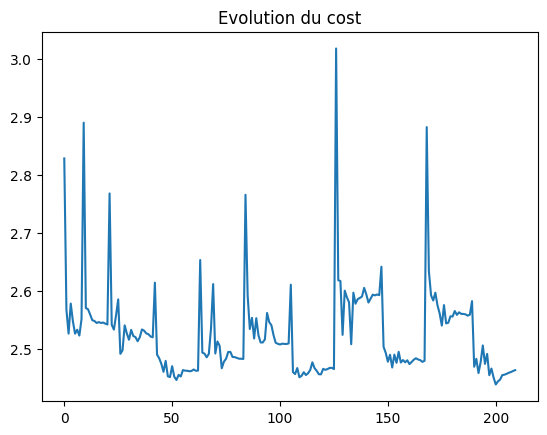

In [3]:
Results =pd.read_csv('./Algo3_Ex1.csv', index_col = 0, header = None)
Algo1 = pd.concat([Results[i] for i in range(3,13)], axis = 0 , ignore_index= True)
Algo1.plot()
plt.title("Evolution du cost")
plt.show
